In [1]:
import os
from datetime import datetime
from pathlib import Path
from src.model_builder import RobinMobilenetV2
from src.helpers import create_dir_if_not_exist, split_train_valid_test
from src.pipelines import create_input_pipelines, \
    train_new_model, fine_tune_model, evaluate_model

materials_data_dir=Path(os.getcwd())/'data/materials'

materials_images_dir= materials_data_dir/'images'
materials_train_dir= materials_data_dir/'train'
materials_valid_dir= materials_data_dir/'valid'
materials_test_dir= materials_data_dir/'test'

model_dir = Path(os.getcwd())/'models'
save_model_materials_dir = model_dir/'materials'
lite_models_dir = model_dir/'lite'

logs_dir = Path(os.getcwd())/'logs'
materials_log = logs_dir/'materials'

project_dir=[
  materials_images_dir,
  materials_train_dir,
  materials_valid_dir,
  materials_test_dir,
  save_model_materials_dir,
  lite_models_dir,
  materials_log,
]

create_dir_if_not_exist(project_dir)

Scanning for necessary directories
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/images
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/train
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/valid
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/test
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/models/materials
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/models/lite
Found directory /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/logs/materials


In [2]:
split_train_valid_test(
    materials_images_dir,
    materials_train_dir,
    materials_valid_dir,
    materials_test_dir,
    0.7,
    0.15
)

Total images found: 995
Train: 696, Validation: 149, Test: 150
Copying 696 of 995 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/train/paper
Copying 149 of 995 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/valid/paper
Copying 150 of 995 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/test/paper
Total images found: 410
Train: 287, Validation: 61, Test: 62
Copying 287 of 410 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/train/metal
Copying 61 of 410 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/valid/metal
Copying 62 of 410 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/test/metal
Total images found: 501
Train: 350, Validation: 75, Test: 76
Copying 350 of 501 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/train/glass
Copying 75 of 501 to /Users/jontan_paloit/Dev/Lab/ROBin-Model-Training/data/materials/valid/glass
Copying 76 of 501 to /Users/

In [2]:
materials_hyperparams = {
    "img_size": (160, 160),
    "channels": 3,
    "batch_size": 32,
    "base_learning_rate": 0.0001,
    "initial_epochs": 1,
    "fine_tune_from": 100,
    "fine_tune_epochs": 1
}

materials_train_ds, materials_validation_ds, materials_test_ds = create_input_pipelines(
    [materials_train_dir, materials_valid_dir, materials_test_dir],
    materials_hyperparams
)

materials_dataset = {
    "train_ds": materials_train_ds,
    "validate_ds": materials_validation_ds,
    "test_ds": materials_test_ds,
    "class_names": materials_train_ds.class_names
}

materials_logdir = materials_log
training_tag = datetime.now().strftime('%Y%m%d_%H%M%S')

Found 1671 files belonging to 4 classes.
Found 357 files belonging to 4 classes.
Found 362 files belonging to 4 classes.


In [3]:
(robin_materials_model, history) = train_new_model(
    model_builder=RobinMobilenetV2,
    hyperparams=materials_hyperparams,
    datasets=materials_dataset,
    log_dir=materials_logdir,
    training_tag=training_tag
)

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)             

12/12 [==============================] - 4s 303ms/step - loss: 1.3328 - accuracy: 0.3812

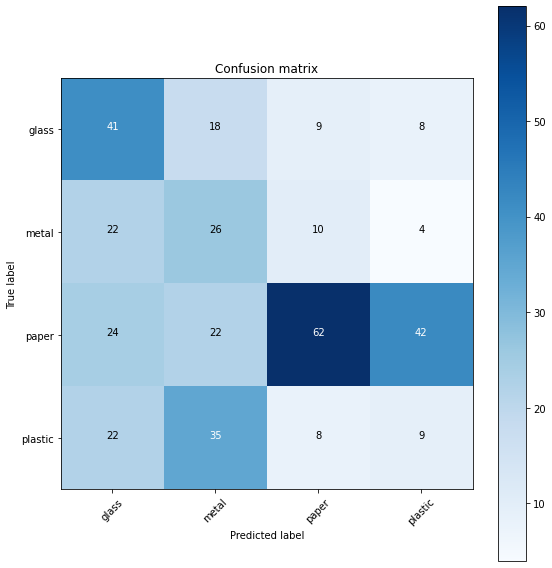

In [6]:
evaluate_model(
    model=robin_materials_model(),
    class_names=materials_dataset['class_names'],
    test_ds=materials_test_ds,
    log_dir=materials_log,
    training_tag=training_tag,
    cm_name="New Classifier",
    log_false_images=False
)

In [7]:
fine_tune_model(
    robin_materials_model,
    materials_hyperparams,
    materials_dataset,
    log_dir=materials_logdir,
    training_tag=training_tag,
    history=history
)

Fine tuning
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv (TensorF [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub (TensorFlowO [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280) 

12/12 [==============================] - 4s 304ms/step - loss: 0.6462 - accuracy: 0.7348

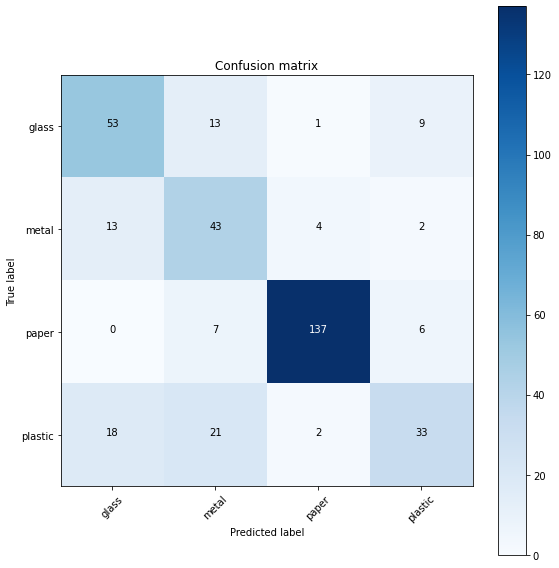

In [8]:
evaluate_model(
    model=robin_materials_model(),
    class_names=materials_dataset['class_names'],
    test_ds=materials_test_ds,
    log_dir=materials_log,
    training_tag=training_tag,
    cm_name="Fine Tune",
    log_false_images=True
)